# Количество заказов такси в аэропорту.

### Введение.

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  
Построим модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

#### Описание данных.

Данные лежат в файле `taxi.csv`.  
Количество заказов находится в столбце '*num_orders*' (*number of orders*).  

#### План работы.

1. Загрузка данных и ресемплирование по одному часу.
2. Анализ данных.
3. Обучение разных моделей с различными гиперпараметрами, проверка на тестовой выборке (10% от исходных данных).  
4. Выводы.

### 1. Загрузка данных и ресемплирование по одному часу.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np

In [2]:
# загрузка данных (с установкой столбца 'datetime' в качестве индекса и сменой типа этого столбца с 'object' на 'datetime')
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# ресемплирование по одному часу
data = data.resample('1H').sum()

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Иной предобработки данных производить не требуется (дополнительные признаки будут созданы позже, во время работы с моделями).

### 2. Анализ данных.

In [7]:
# проверка на хронологию
data.index.is_monotonic

True

In [8]:
# границы временного промежутка
print (data.index[0])
print (data.index[len(data)-1])

2018-03-01 00:00:00
2018-08-31 23:00:00


Изучим тренды и сезонность.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [10]:
decomposed = seasonal_decompose(data)

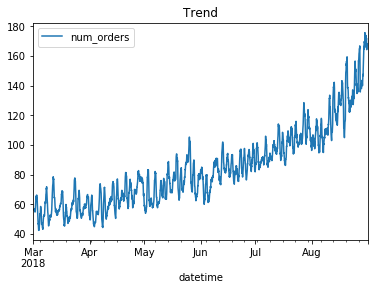

In [11]:
# тренд за весь период наблюдений
decomposed.trend.plot(title='Trend')

Как видим, количество заказов растет, особенно заметен рост в августе.

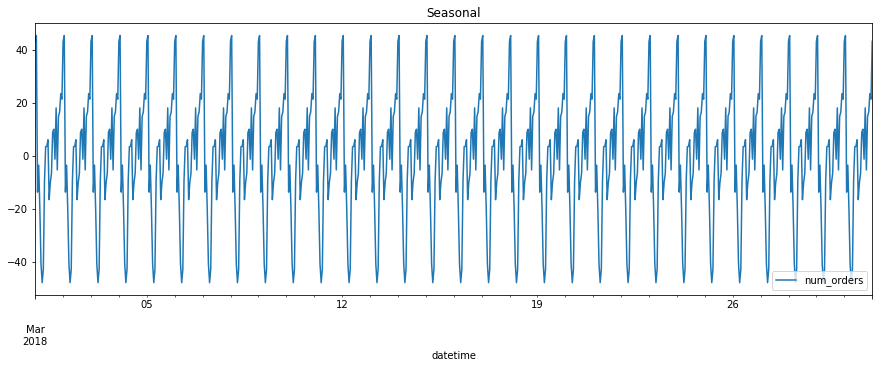

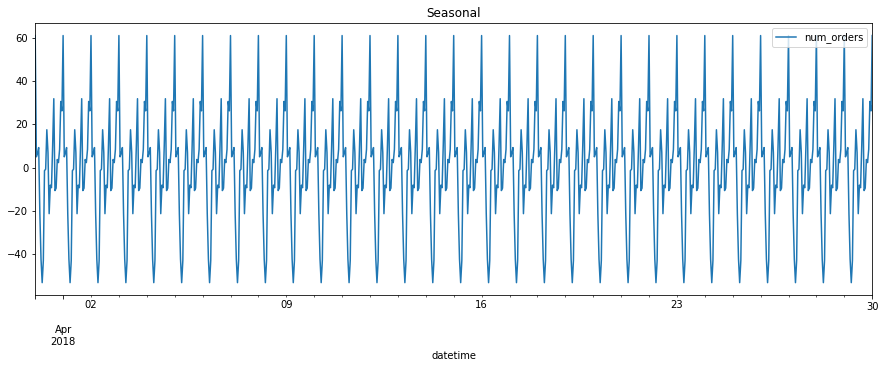

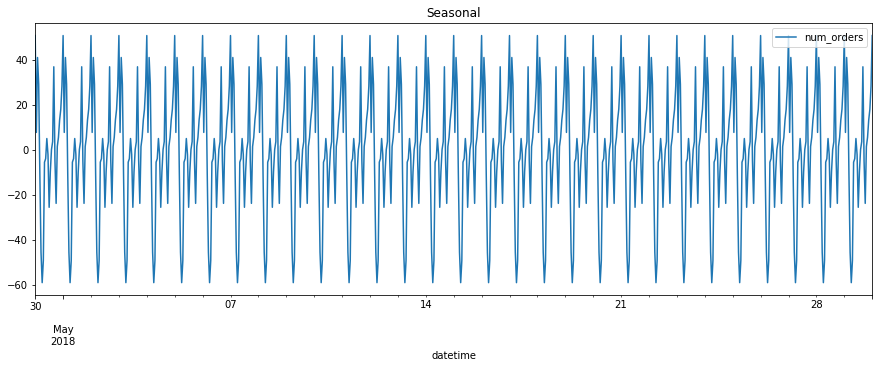

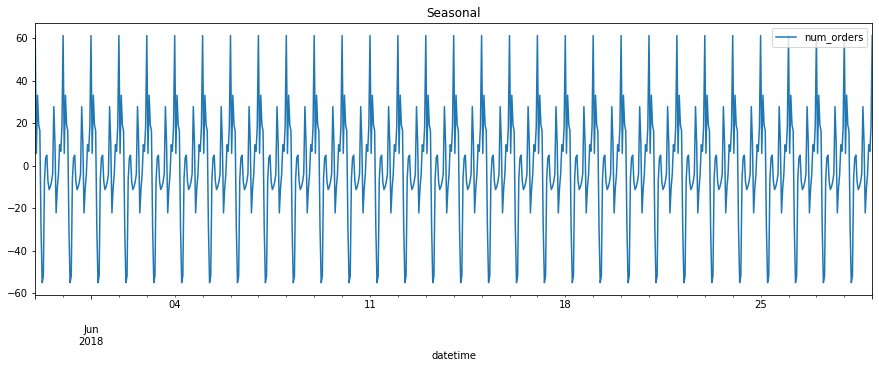

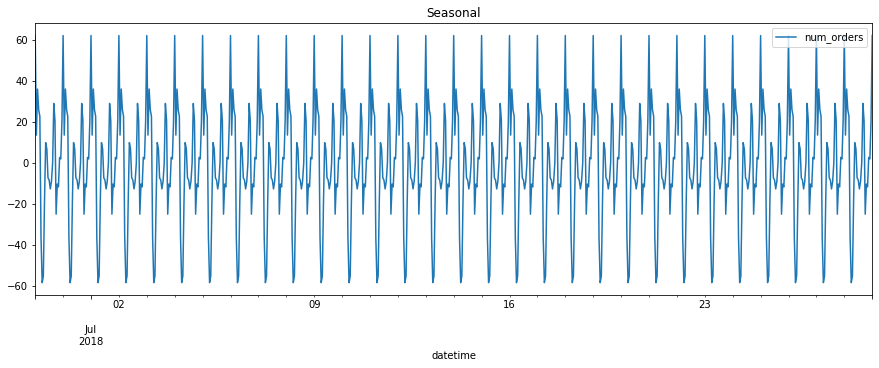

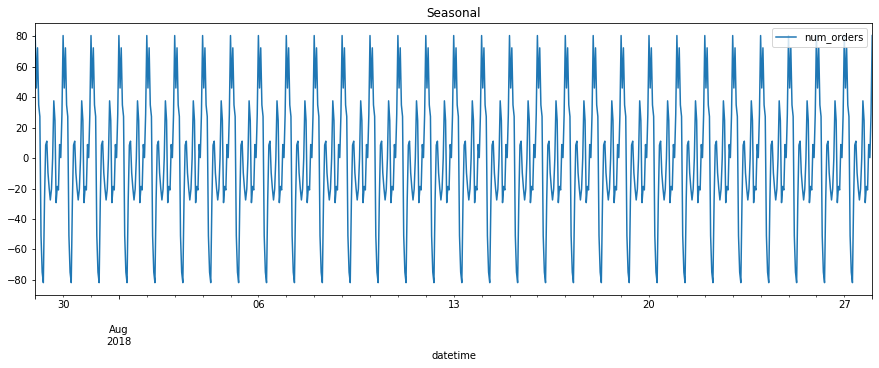

In [12]:
# чтобы закономерности, циклично повторяющиеся в течении дня, были заметны на графике,
# сезонность отобразим для каждого месяца отдельно, такого масштаба будет достаточно
for d in range (0, len(data)-24*30, 24*30):
    d1 = data.index[d]
    d2 = data.index[d] + 24*30*data.index.freq
    decomposed_monthly = seasonal_decompose(data[d1:d2])
    decomposed_monthly.seasonal.plot(figsize=(15,5), title='Seasonal')

Стабильно наблюдается падение числа заказов в первой половине и рост во второй половине суток.

### 3. Обучение моделей и тестирование.

Напишем функцию make_features(), чтобы прибавить к таблице три календарных признака: месяц, день и день недели, а также отстающие значения и скользящее среднее.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['month']=data.index.month
    data['day']=data.index.day
    data['dayofweek']=data.index.dayofweek
    data['hour']=data.index.hour
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)]=data['num_orders'].shift(lag)
    data['rolling_mean']=data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [15]:
# заготовка таблицы вывода параметров и результатов работы моделей
columns=['method', 'rmse_valid', 'rmse_test', 'max_lag','rolling_mean_size', 'n_estimators', 'max_depth']
lines=[]

In [16]:
pd.set_option('display.max_rows', None)

In [17]:
%%time

for max_lag in range(12,25,4):
    for rolling_mean_size in range(4,13,2):
        
        # создание признаков
        make_features(data, max_lag, rolling_mean_size)
        
        # выделение тестовой выборки (10% от исходных данных)
        data1, test = train_test_split(data, test_size=0.1, shuffle=False)
        data1 = data1.dropna() # выборка "обучающая+валидационная"
        
        # выделение обучающей и валидационной выборок
        train, valid = train_test_split(data1, test_size=0.1, shuffle=False)
        
        # обучающие признаки и целевой признак
        features_data1 = data1.drop(columns = ['num_orders'])
        target_data1 = data1['num_orders']
        features_train = train.drop(columns = ['num_orders'])
        target_train = train['num_orders']
        features_valid = valid.drop(columns = ['num_orders'])
        target_valid = valid['num_orders']
        features_test = test.drop(columns = ['num_orders'])
        target_test = test['num_orders']
        
        # создание разных моделей
        for method in ['linear_regression','random_forest','decision_tree']:
            if method == 'linear_regression':
                model = LinearRegression()
                n_estimators = np.nan
                max_depth = np.nan
            if method =='random_forest':
                for estim in range(10, 51, 10):
                    for depth in range(6, 11, 2):
                        model = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
                        n_estimators = estim
                        max_depth = depth
            if method =='decision_tree':
                for depth in range(6, 11, 2):
                    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
                    n_estimators = np.nan
                    max_depth = depth
            
            # обучение модели на обучающей выборке
            model.fit(features_train, target_train)
        
            # работа модели и вычисление RMSE на валидационной выборке
            pred_valid = model.predict(features_valid)
            rmse_valid = mse(target_valid, pred_valid)**0.5
            
            # обучение модели на выборке "обучающая+валидационная" - подготовка к тестированию
            model.fit(features_data1, target_data1) 
        
            # работа модели и вычисление RMSE на тестовой выборке
            pred_test = model.predict(features_test)
            rmse_test = mse(target_test, pred_test)**0.5
             
            # добавление данных в таблицу результатов
            line = [method, rmse_valid, rmse_test, max_lag, rolling_mean_size, n_estimators, max_depth]
            lines.append(line)
            
            # удаление добавленных признаков - подготовка к следующей итерации
            data = pd.DataFrame(data['num_orders'])

CPU times: user 1min 24s, sys: 2.63 s, total: 1min 26s
Wall time: 1min 28s


In [18]:
# таблица результатов, параметров новых признаков и параметров моделей
summary = pd.DataFrame(data=lines, columns=columns).sort_values(by='rmse_valid').reset_index(drop=True)
summary

,method,rmse_valid,rmse_test,max_lag,rolling_mean_size,n_estimators,max_depth
0,random_forest,31.334339,45.788591,20,10,50.0,10.0
1,random_forest,31.699554,46.442643,20,4,50.0,10.0
2,random_forest,31.705441,46.888419,20,12,50.0,10.0
3,random_forest,31.791597,45.215255,16,10,50.0,10.0
4,random_forest,31.868927,44.825874,16,4,50.0,10.0
5,random_forest,32.000125,45.163913,16,12,50.0,10.0
6,random_forest,32.016594,44.735818,16,6,50.0,10.0
7,random_forest,32.084728,45.507561,16,8,50.0,10.0
8,random_forest,32.118009,45.843674,20,6,50.0,10.0
9,random_forest,32.119456,43.012219,24,6,50.0,10.0


Выберем лучшие варианты каждой модели по результату на валидационной выборке.

In [19]:
# линейная регрессия
summary_lr = summary[summary['method']=='linear_regression']
best_lr = summary_lr[summary_lr['rmse_valid']==summary_lr['rmse_valid'].min()]

In [20]:
# случайный лес
summary_rf = summary[summary['method']=='random_forest']
best_rf = summary_rf[summary_rf['rmse_valid']==summary_rf['rmse_valid'].min()]

In [21]:
# рещающее дерево
summary_dt = summary[summary['method']=='decision_tree']
best_dt = summary_dt[summary_dt['rmse_valid']==summary_dt['rmse_valid'].min()]

In [22]:
# лучшие варианты каждой модели в сравнении
summary_best = pd.concat([best_lr,best_rf,best_dt]).sort_values(by='rmse_test').reset_index(drop=True)
summary_best

,method,rmse_valid,rmse_test,max_lag,rolling_mean_size,n_estimators,max_depth
0,random_forest,31.334339,45.788591,20,10,50.0,10.0
1,linear_regression,34.152619,45.812404,24,10,NaN,NaN
2,decision_tree,34.105876,53.311200,12,12,NaN,10.0


In [23]:
# среднее количество заказов в час за период наблюдения
data['num_orders'].mean()

84.42278079710145

### 4. Вывод.

Удалось достичь требуемого результата (RMSE <= 48) моделями "линейная регрессия" и "случайный лес".  
Хотя поставленная задача и выполнена, но, если сравнить значение метрики со средним количеством заказов в час, то мы имеем точность предсказания всего лишь +/-55%.